# Create ML DataFrame

25 July 2025 


In [2]:
# Import Python Libraries 

import sys
import os
import pickle
import time 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from pandasql import sqldf
import sqlalchemy
import snowflake.connector

import pyodbc

from tqdm import tqdm

import Utilities
import importlib
importlib.reload(Utilities)

import re
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)



# show all dataframe columns 

pd.set_option('display.max_columns', None)

## Read in datasets 

In [3]:
date = '2025_07_25'


# I prefer using the glob module, as it does pattern matching and expansion.
import glob
print(glob.glob("Data\Input_Files\{}*".format(date)))

# input_frames = [] 

# with open(Data_Storage_File, 'rb') as file:  
#     check = pd.read_pickle(file)  

dataframe_dict = {}


for f in glob.glob("Data\Input_Files\{}*".format(date)):
    with open(f, 'rb') as inputFile:
        tmp = pd.read_pickle(inputFile)
        dataframe_dict[tmp.attrs['Name']] = tmp



['Data\\Input_Files\\2025_07_25_client_df.pkl', 'Data\\Input_Files\\2025_07_25_ed_status_df.pkl', 'Data\\Input_Files\\2025_07_25_ed_visits_df.pkl', 'Data\\Input_Files\\2025_07_25_gcs_df.pkl', 'Data\\Input_Files\\2025_07_25_icu_df.pkl', 'Data\\Input_Files\\2025_07_25_ip_visits_df.pkl', 'Data\\Input_Files\\2025_07_25_pathology_df.pkl', 'Data\\Input_Files\\2025_07_25_vital_signs_df.pkl']


In [4]:
# dataframe_dict = {}
# for item in input_frames:
#     # print(item.attrs['Name'])
#     dataframe_dict[item.attrs['Name']] = item

In [5]:
ed_visits_df = dataframe_dict['ed_visits_df']
ed_status_df =   dataframe_dict['ed_status_df'] # Not used yet 
ip_visits_df = dataframe_dict['ip_visits_df']
vital_signs_df = dataframe_dict['vital_signs_df']
gcs_df = dataframe_dict['gcs_df']
pathology_df = dataframe_dict['pathology_df']
icu_df = dataframe_dict['icu_df']
client_df = dataframe_dict['client_df']

In [6]:
def qSofa(row):
    value = 0
    resp = (row['Respiration (breaths/min)'])
    gcs = (row['GCS Score'])
    bp = (row['BP Systolic (mm Hg)'])
    IsNaN = pd.isna(resp) and pd.isna(gcs) and pd.isna(bp)
    if IsNaN:
        return None 
        # try:
    if not pd.isna(gcs):
        if int(gcs)<15: value+=1
    if not pd.isna(bp):
        if int(bp)<=100: value+=1
    if not pd.isna(resp):
        if int(resp)>=22:value+=1
        # except:
        # print(gcs,bp,resp)
    return value

def qSirs(row):
    value = 0
    resp = (row['Respiration (breaths/min)'])
    hr = (row['Pulse Rate (beats/min)'])
    wbc = (row['White Cell Count'])
    temp = (row['Temperature (degrees C)'])
    IsNaN = pd.isna(resp) or pd.isna(hr) or pd.isna(temp)
    if IsNaN:
        return None 
    else:
        # try:
        if int(resp)>20: value+=1
        if int(hr)<=90: value+=1
        if not pd.isna(wbc):
            if int(wbc)>=12:value+=1
        if float(temp) >38.:
            value+=1
        elif float(temp)<36.:
            value+=1
        # except:
        # print(gcs,bp,resp)
    return value

def qSirsSevere(row):
    value = 0
    sirs = (row['qSIRS'])
    lact = (row['Lactate'])
    bp = (row['BP Systolic (mm Hg)'])
    IsNaN = pd.isna(sirs)
    if IsNaN:
        return None 
    elif sirs>1:
        # try:
        if not pd.isna(sirs):
            if float(lact)>4: value+=1
        if not pd.isna(bp):
            if int(bp)<=90:value+=1

        # except:
        # print(gcs,bp,resp)
    return value

def timeDiff(first_dtm, second_dtm):
    """
    Calculates the datetime difference between two datetimes  in days. 
    In this case the end date corresponds to ED discharge so if NAT 
    sets to zero as by definition goes straight to ward. 
    
    Parameters
    ----------
    first_dtm: datetime 
        datetime of first event
        
    second_dtm: datetime 
        datetime of second event
    
    Returns
    -------
    diff: float
        time difference measured in days 
    """
    # print(first_dtm,second_dtm)
    if pd.isna(second_dtm) == False:
        if pd.isna(first_dtm) == False:
            diff = (second_dtm - first_dtm)/np.timedelta64(1, 'm')
        else: 
            diff = None
    else: 
        diff = None
    return diff

def timeDiffMortality(first_dtm, second_dtm,ed_dtm):
    """
    Calculates the datetime difference between two datetimes  in days. 
    In this case the end date corresponds to ED discharge so if NAT 
    sets to zero as by definition goes straight to ward. 
    
    Parameters
    ----------
    first_dtm: datetime 
        datetime of first event
        
    second_dtm: datetime 
        datetime of second event
    
    Returns
    -------
    diff: float
        time difference measured in days 
    """
    if pd.isna(second_dtm) == False:
        if pd.isna(ed_dtm) == False:
            diff = (second_dtm - ed_dtm)/np.timedelta64(1, 'D')
        else:
            diff = (second_dtm - first_dtm)/np.timedelta64(1, 'D')
    else: 
        diff = None
    return diff


NUMBER_NOT_NULL
5    437424
4     68585
3     18334
Name: count, dtype: int64


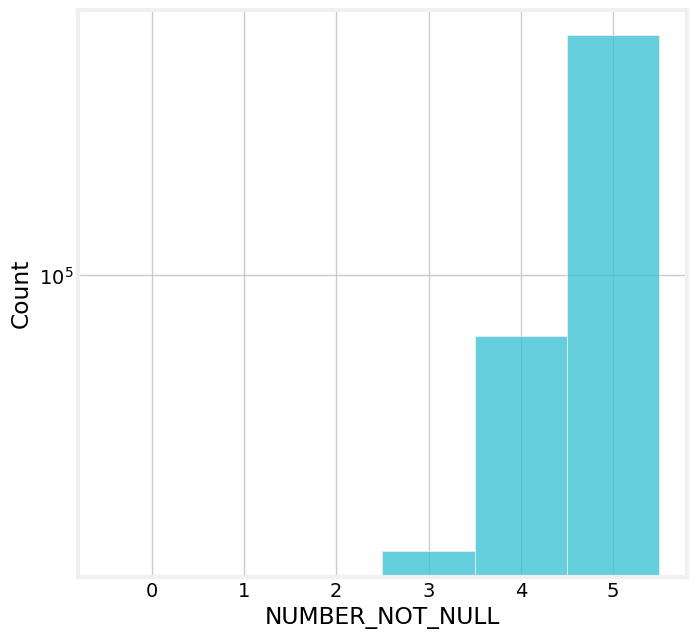

In [7]:
from matplotlib.colors import to_rgba

plt.style.use('./CEIH.mplstyle')
color_dict = {0: to_rgba('#32C0D2', 1),
                1: to_rgba("#E0B165", 1),}

tmp_df = vital_signs_df.loc[vital_signs_df.VITALS_SEQ_BY_VISIT==1].copy()
print(tmp_df.NUMBER_NOT_NULL.value_counts())
fig, ax = plt.subplots(figsize=(7, 7))
sns.histplot(data=tmp_df,x="NUMBER_NOT_NULL",binrange=[-0.5,5.5],binwidth=1,label="Number of Vital Signs Recorded")
plt.yscale('log')

In [8]:
colums_to_keep = ['JOURNEY_ID','CLIENTGUID','VISITGUID', 'CHARTGUID', 'ADMITDTM','DISCHARGEDTM','AGEONADMIT','TRIAGE_CATEGORY','DISCHARGEDISPOSITION','HOSPITAL','FIRSTTRIAGEVALUE']

In [9]:
ip_visits_df['IP_ED_Overlap'] = ip_visits_df.apply(lambda row: timeDiff(row['PRE_DISCHARGEDTM'],row['DISCHARGEDTM']), axis=1)

In [10]:
dropidx = ip_visits_df[ip_visits_df.CURRENTLOCATION.str.contains('Admin')].index   #.CURRENTLOCATION.unique()
ip_visits_clean_df = ip_visits_df.drop(dropidx)

In [11]:
dropidx_short = ip_visits_clean_df[(ip_visits_clean_df.IP_ED_Overlap<60)&(~ip_visits_clean_df.DISCHARGEDISPOSITION.str.contains('Died'))].index

In [12]:
ip_visits_clean_df.drop(dropidx_short,inplace=True)

In [ ]:
ip_cols_to_keeep  = [ 'PRIMARY_SEPSIS', 'ANY_SEPSIS', 'JOURNEY_ID','VISITGUID', 'CHARTGUID', 'ADMITDTM','DISCHARGEDTM','PRE_ADMITDTM',	'PRE_DISCHARGEDTM', 'ADMITDTM','DISCHARGEDTM','AGEONADMIT','MORTALITY_INDICATOR','DISCHARGEDISPOSITION','ALLCHARDIAGNOSIS','CURRENTLOCATION','IP_ED_Overlap','HOSPITAL','MODE_OF_ARRIVAL',	'MODE_OF_ARRIVAL_TYPE']

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2886112331.py, line 1)

In [14]:
vitals_to_keep = ['VITALS_SEQ_BY_VISIT', 'NUMBER_NOT_NULL', 'CLIENTVISITGUID',
       'AUTHOREDDTM', 'Purple zone', 'Red zone',
       'Yellow zone', 'Pulse Rate (beats/min)', 'Temperature (degrees C)',
       'BP Systolic (mm Hg)', 'BP Diastolic (mm Hg)', 'O2 Flow (L/min)',
       'Sedation Score', 'Resting Pain Score', 'Respiration (breaths/min)',
       'Pain: New/Unexpected', 'SpO2 (%)']

In [15]:
gcs_to_keep = ['CLIENTVISITGUID','GCS Score']

In [16]:
ed_visits_df.head()

,ED_SEQ_BY_JOURNEY,JOURNEY_ID,JOURNEY_ID_OLD,CLIENTGUID,SAUHI,RANK,EPISODE_ID,VISITGUID,CHARTGUID,ADMITDTM,DISCHARGEDTM,DISCHARGEDISPOSITION,PRE_VISITGUID,PRE_CHARTGUID,PRE_ADMITDTM,PRE_DISCHARGEDTM,PRE_DISCHARGEDISPOSITION,DISCHARGELOCATION,VISITIDCODE,AGEONADMIT,DOB,AGE,SUBURB,POSTCODE,HOMELHN,MH_CATCHMENT,SEIFA_RELATIVE_DISADVANTAGE,IRSD_SCORE,IRSD_DECILE,IRSAD_SCORE,IRSAD_DECILE,IER_SCORE,IER_DECILE,IEO_SCORE,IEO_DECILE,IRSD_GROUP,USUALACCOMODATIONTYPE,HOSPITAL,HOSPITALNAME,METROCOUNTRYFLAG,TYPECODE,CARELEVELCODE,CURRENTLOCATIONGUID,CURRENTLOCATION,WARD,WARD_DESC,WARD_TYPE,WARD_CAPACITY,REHAB_WARD_TYPE,REHAB_HITH_FLAG,ADMISSIONREQUESTDATETIME,GROUPCODE,SERVICEDESCRIPTION,SUBGROUPCODE,SUBGROUP_DESCRIPTION,CLINICCODE,CLINICNAME,ADMITSOURCE,ADMISSIONCATEGORY,EPISODEOFCARE,PATIENTCATEGORY,ADMISSIONTYPE,ADMISSIONELECTION,SOURCEOFREFERRAL,LOSNIGHTS,LOSHOUR,LOS_GROUPS,MORTALITY_INDICATOR,SAH_DIAGNOSIS,DIAGNOSISCODE,ED_CODE_2,ED_CODE_3,DIAGNOSIS_CODE_DESC,ALLDIAGNOSIS,ALLCHARDIAGNOSIS,ALLDIAGNOSISHOSPITAL,ALLCHARDIAGNOSISHOSPITAL,PROCEDURECODE,PROCEDURE_CODE_DESC,ALLPROCEDURES,LEGALSTATUSCODE,LEGALSTATUSDESCRIPTION,DRG,MDC,ECCS,NWAU,TILESEPISODEOFCARE,TILESDISCHARGEDISPOSITION,ICUVENTHOURS,TOTALMVHOURS,DICTIONARYREASONS,MODE_OF_ARRIVAL,MODE_OF_ARRIVAL_TYPE,TRIAGE_CATEGORY,SAAS_ORG_EVENT_NUMBER,SAAS_ORG_DISPATCH_NUMBER,ED_ORG_EVENT_NUMBER,ED_ORG_DISPATCH_NUMBER,SAAS_INCIDENT_PRIORITY,DESTINATIONARRIVALDATETIME,TRIAGEASSESSMENTDESCRIPTION,TRIAGEASSESSMENTSUBDESCRIPTION,LOCATIONCOMMONPLACENAME,LOCATIONPRIMARYCOMMONPLACENAME,LOCATIONCOMMONPLACETYPE,DESTINATIONCOMMONPLACENAME,DESTINATIONPRIMARYCOMMONPLACENAME,DESTINATIONCOMMONPLACETYPE,DISPOSITIONTYPECODE,DISPOSITIONTYPEDESCRIPTION,DESTINATIONFLAG,PATIENTHANDOVERDATETIME,AROC_RECORD_TYPE,AROC_NOTE_FLAG,MH_WARD_TYPE,TREATED_IN_MH_WARD,DEMENTIA_FLAG,MENTAL_HEALTH_ECT_TREATMENT_FLAG,MENTAL_HEALTH_ECT_JOURNEY_FLAG,JOURNEY_ACCURACY,JOURNEY_HOSPITAL_TYPE,FREQUENT_VISITOR_FLAG,MENTAL_HEALTH_FLAG_BYDIAGNOSIS,MENTAL_HEALTH_FLAG_BYJOURNEY,CLOZAPINE_FLAG_BYJOURNEY,MENTAL_HEALTH_FLAG_BYJOURNEY_MHWARD,REHAB_FLAG_BYJOURNEY,EDI_REHAB_AGECARE_FLAG_BYJOURNEY,MAINTENANCE_FLAG_BYVISIT,REHAB_FLAG_BYVISIT,GEM_FLAG_BYVISIT,ED_24HRS_IP_ADMISSION_FLAG,PATIENT_ED_24HRS_IP_ADMISSION_FLAG,CHRONIC_DIAGNOSIS,ONSITE_WARD_FLAG,EDI_REHAB_AGECARE_FLAG_BYVISIT,TreatmentStartedDtm,TREATMENTSTARTEDMINS,AdmissionRequestDtm,ADMISSIONREQUESTMINS,FIRSTTRIAGEVALUE,LASTTRIAGEVALUE,FIRSTTRIAGEDTM
0,1,22454301634741464539-117,1206580 - 17,20674400200,100006650541,1,17,2371812900270,1708559100170,2023-05-24 10:28:00+00:00,2023-05-24 13:00:00+00:00,ED02 Admit as Inpatient,2.349430e+12,1.695312e+12,2023-05-11 02:43:00+00:00,2023-05-11 07:00:00+00:00,IP Home,None,112835296,50,1973-02-02,52,HACKHAM WEST,5163,SALHN,Southern Adelaide LHN,851.0,906,1,876,1,939,2,873,1,Low,Private Residence,NHS,Noarlunga Hospital,M,Emergency,Emergency,265400610,NHS-ED-SWB,ED,None,None,NaN,None,0,2023-05-24 12:38:00+00:00,NHS-EMERG,NHS Emergency,None,NHS Emergency,None,Emergency,ED Self-Family-Friends,Emergency,None,None,None,None,ED Self-Family-Friends,0,3,Same day,Didnt Die,"Complication of surgical and medical care, uns...",T889,None,T889,Comp surgical & medical care unsp,None,None,None,None,None,None,None,3,Voluntary,None,None,None,None,None,None,None,None,None,Private Car,Non Ambulance,4,None,None,None,None,None,NaT,None,None,None,None,None,None,None,None,None,None,None,NaT,None,Not Applicable,Other,N,0,N,N,Accurate Journey,All Metro,Y,N,N,N,N,N,N,N,N,N,N,N,Not Chronic,Y,N,2023-05-24 21:15:00+09:30,77.0,2023-05-24 12:38:00+00:00,130.0,4,4,2023-05-24 10:32:41.703000+00:00
1,1,32322171454741464540-101,3864116 - 1,305422700200,100010467775,1,1,2357888800270,1700353700170,2023-05-15 11:25:00+00:00,2023-05-15 15:53:00+00:00,ED01 Discharged Home,NaN,NaN,NaT,NaT,None,None,112734884,48,1975-10-11,50,SHEIDOW PARK,5158,SALHN,Southern Adelaide LHN,1066.0,1055,8,1016,7,1051,8,999,7,High,Private Residence,FMC,Flinders Medical Centre,M,Emergency,Emergency,22183006

In [15]:
temp_0_df = ed_visits_df[colums_to_keep].copy()

temp_1_df = pd.merge(temp_0_df,client_df,left_on='CLIENTGUID',right_on='CLIENTGUID',how='left')
temp_2_df = pd.merge(temp_1_df,ip_visits_clean_df[ip_cols_to_keeep],left_on='JOURNEY_ID',right_on='JOURNEY_ID',suffixes=(None,'_IP'),how='left')
tmp_df = vital_signs_df.loc[vital_signs_df.VITALS_SEQ_BY_VISIT==1].copy()
temp_3_df = pd.merge(temp_2_df,tmp_df[vitals_to_keep],left_on='VISITGUID',right_on='CLIENTVISITGUID',suffixes=(None,'_Vitals'),how='left')
tmp_df = gcs_df.loc[gcs_df.GCS_SEQ_BY_VISIT==1][gcs_to_keep].copy()
temp_3_df = pd.merge(temp_3_df,tmp_df,left_on='VISITGUID',right_on='CLIENTVISITGUID',how='left')
temp_3_df = pd.merge(temp_3_df,icu_df,left_on='VISITGUID_IP',right_on='VISITGUID',how='left',suffixes=(None,'_icu'))

sepsis_df = temp_3_df
sepsis_df.drop(columns=['CLIENTVISITGUID_x','CLIENTVISITGUID_y','VISITGUID_icu'],axis=1,inplace=True)


sepsis_df['PRIMARY_SEPSIS'] = sepsis_df['PRIMARY_SEPSIS'].fillna(0)
sepsis_df['ANY_SEPSIS'] = sepsis_df['ANY_SEPSIS'].fillna(0)



In [16]:
int_columns = [ 'CLIENTGUID', 'VISITGUID', 'CHARTGUID',  'AGEONADMIT', 
        'PRIMARY_SEPSIS', 'ANY_SEPSIS',
       'VISITGUID_IP', 'CHARTGUID_IP',
       'AGEONADMIT_IP', 
       'VITALS_SEQ_BY_VISIT', 'NUMBER_NOT_NULL',
       'Purple zone', 'Red zone', 'Yellow zone',
       'Pulse Rate (beats/min)', 
       'BP Systolic (mm Hg)', 'BP Diastolic (mm Hg)', 
       'Sedation Score', 'Resting Pain Score', 'Respiration (breaths/min)',
       'SpO2 (%)', 'GCS Score']


float_cols = ['Temperature (degrees C)', 'O2 Flow (L/min)',]

In [17]:
sepsis_df['AGERANGE_ON_ADMIT2'] = np.where(sepsis_df.AGEONADMIT>84,'85+',
                                                np.where(sepsis_df.AGEONADMIT>64,'65 - 84',
                                                np.where(sepsis_df.AGEONADMIT>34,'35 - 64','<35')))
age_range_order = [ '<35','35 - 64', '65 - 84', '85+']
sepsis_df['AGERANGE_ON_ADMIT2'] = pd.Categorical(sepsis_df['AGERANGE_ON_ADMIT2'],categories=age_range_order,ordered=True)

In [18]:
sepsis_df['IndiginousFlag'] = 0  # np.where((Emergency_IPInfo_Complete_Numeric.IndiginousStatus.isna()|Emergency_IPInfo_Complete_Numeric.IndiginousStatus=='Not Aboriginal-TSI'),0,1)
sepsis_df.loc[sepsis_df.RACECODE.isin(['Aboriginal','Aboriginal and TSI', 'TSI']),'IndiginousFlag'] = 1


In [19]:
cols = ['Pulse Rate (beats/min)',
       'Temperature (degrees C)', 
       'BP Systolic (mm Hg)',
       # 'BP Diastolic (mm Hg)', 
    #    'O2 Flow (L/min)', 
    #    'Sedation Score',
       # 'Resting Pain Score', 
       'Respiration (breaths/min)',
       # 'Pain: New/Unexpected', 
       'SpO2 (%)',]
sepsis_df['number_of_NaNs'] = sepsis_df[cols].isna().sum(1)

In [20]:
for col in int_columns:
    # print(col)
    sepsis_df[col] = sepsis_df[col].astype('Int64')


In [21]:
# sepsis_df['qSOFA'] = np.where(sepsis_df['Respiration (breaths/min)']>=22) #np.where(sepsis_df['GCS Score']<15,1,0) #+
sepsis_df['qSOFA'] =    sepsis_df.apply(lambda row: qSofa(row), axis = 1)


In [22]:
sepsis_df['qSOFA'].value_counts(dropna=False)

qSOFA
0.0    420987
NaN     99013
1.0     90247
2.0     11783
3.0       823
Name: count, dtype: int64

## Pathology Tests 

- White Blood Count 
- Lactate Level 


In [23]:
# white_blood_count_df =  
tmp = pathology_df.loc[(pathology_df.RESULTITEMGUID==1588201010)&(pathology_df.TIME_HOURS<36)].copy()
tmp.dropna(subset=['VALUE'],inplace=True)
tmp['VALUE'] = pd.to_numeric(tmp['VALUE'])
white_blood_count = tmp.sort_values(['VISITGUID','TIME_HOURS']).groupby('VISITGUID').head(1).copy()
white_blood_count.rename(columns={'VALUE':'White Cell Count'},inplace=True)

In [24]:
tmp = pathology_df.loc[(pathology_df.RESULTITEMGUID.isin([2202601010,2215501010]))&(pathology_df.TIME_HOURS<36)].copy()
tmp.dropna(subset=['VALUE'],inplace=True)
tmp['VALUE'] = tmp['VALUE'].replace({'>30.0':'30.0','<0.2':'0.1'})
tmp['VALUE'] = pd.to_numeric(tmp['VALUE'])
lactate_blood_gas = tmp.sort_values(['VISITGUID','TIME_HOURS']).groupby('VISITGUID').head(1).copy()
lactate_blood_gas.rename(columns={'VALUE':'Lactate'},inplace=True)

In [25]:
# dups = white_blood_count.VISITGUID.value_counts()
# dups2 = dups[dups.gt(1)]
# dups2

In [26]:
sepsis_path_df = pd.merge(sepsis_df,white_blood_count[['VISITGUID','White Cell Count']],left_on='VISITGUID',right_on='VISITGUID',how='left')
sepsis_path_df = pd.merge(sepsis_path_df,lactate_blood_gas[['VISITGUID','Lactate']],left_on='VISITGUID',right_on='VISITGUID',how='left')
sepsis_df = sepsis_path_df.copy()

In [27]:
sepsis_df['qSIRS'] =    sepsis_df.apply(lambda row: qSirs(row), axis = 1)


In [28]:
sepsis_df['qSIRS_Severe'] =    sepsis_df.apply(lambda row: qSirsSevere(row), axis = 1)


In [29]:
diagnosis_code_df = pd.read_csv("Original_Code/_DIM_Diagnosis_Codes__202405071653.csv")
# display(diagnosis_code_df.head())
diagnosisList = [
            "A021",
            "A227",
            "A267",
            "A327",
            "A40",
            "A400",
            "A401",
            "A402",
            "A403",
            "A408",
            "A409",
            "A41",
            "A410",
            "A411",
            "A412",
            "A413",
            "A414",
            "A415",
            "A4150",
            "A4151",
            "A4152",
            "A4158",
            "A418",
            "A419",
            "A427",
            "B377",
            "O85",

            "R651" ]

# 2023 Data Sample 

In [30]:
sepsis_2023_sample_df = sepsis_df.loc[(sepsis_df.DISCHARGEDTM<'2024-01-01')&(sepsis_df.DISCHARGEDTM>'2023-01-01')].copy()
num_presentations_2023 = len(sepsis_2023_sample_df.index)
print(sepsis_2023_sample_df.NUMBER_NOT_NULL.value_counts( dropna=False))

sepsis_2023_sample_df.dropna(subset=['NUMBER_NOT_NULL'],inplace=True)
num_presentations_2023_Three_VS = len(sepsis_2023_sample_df.index)
print("\nThere are {} ED presentations in 2023 of which {} presentations have at least 3 vital signs of interest.\n".format(num_presentations_2023,num_presentations_2023_Three_VS))

print(sepsis_2023_sample_df.ANY_SEPSIS.value_counts(dropna=False))
print(sepsis_2023_sample_df.PRIMARY_SEPSIS.value_counts(dropna=False))

NUMBER_NOT_NULL
5       215525
<NA>     52233
4        35798
3         9273
Name: count, dtype: Int64

There are 312829 ED presentations in 2023 of which 260596 presentations have at least 3 vital signs of interest.

ANY_SEPSIS
0    258039
1      2557
Name: count, dtype: Int64
PRIMARY_SEPSIS
0    259676
1       920
Name: count, dtype: Int64


In [31]:
print(len(diagnosisList))
# temp_df = df_verification.loc[df_verification.SepsisFlag==1].copy()
temp_df  = sepsis_2023_sample_df.loc[sepsis_2023_sample_df['ANY_SEPSIS']==1].copy()
for diag in diagnosisList:
    desc = diagnosis_code_df[diagnosis_code_df["diagnosis_code"]==diag].diagnosis_code_desc.values[0]
    diagnosis_count = temp_df.loc[temp_df.ALLCHARDIAGNOSIS.str.contains(diag)].ANY_SEPSIS.sum()
    print("{}\t{}\t{}".format(diag,diagnosis_count,desc))

28
A021	5	Salmonella sepsis
A227	0	Anthrax sepsis
A267	0	Erysipelothrix sepsis
A327	0	Listerial sepsis
A40	197	Streptococcal sepsis
A400	38	Sepsis dt streptococcus group A
A401	25	Sepsis dt streptococcus group B
A402	52	Sepsis dt streptococcus group D
A403	22	Sepsis dt Streptococcus pneumoniae
A408	61	Other streptococcal sepsis
A409	4	Streptococcal sepsis unspecified
A41	2349	Other sepsis
A410	106	Sepsis due to Staphylococcus aureus
A411	39	Sepsis dt other spec staphylococcus
A412	8	Sepsis due to unsp staphylococcus
A413	2	Sepsis dt Haemophilus influenzae
A414	14	Sepsis due to anaerobes
A415	405	Sepsis dt oth & unsp gram neg organisms
A4150	12	Sepsis dt unsp Gram neg organisms
A4151	262	Sepsis dt Escherichia coli (E coli)
A4152	45	Sepsis due to Pseudomonas
A4158	100	Sepsis dt other gram neg organisms
A418	86	Other specified sepsis
A419	1710	Sepsis, unspecified
A427	1	Actinomycotic sepsis
B377	22	Candidal sepsis
O85	11	Puerperal sepsis
R651	0	SIRS infect origin w ac organ failure


In [59]:
temp_df = sepsis_2023_sample_df.loc[sepsis_2023_sample_df['ANY_SEPSIS']==0].copy()
temp_df['MORTALITY_INDICATOR'] =  pd.Categorical(temp_df['MORTALITY_INDICATOR'] )


temp_df["MortalityAfterAdmissionDays"] = temp_df.apply(lambda row: timeDiffMortality(row['ADMITDTM'],row['DECEASEDDTM'], row['ADMITDTM']), axis = 1)
temp_df['Died30DaysAfterAdmission'] = 0
temp_df.loc[(temp_df.MortalityAfterAdmissionDays<31), 'Died30DaysAfterAdmission'] = 1

groupedBy = 'FIRSTTRIAGEVALUE'
# groupedBy = 'HOSPITAL'
# groupedBy ='number_of_NaNs'

EoC = temp_df[['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
EoC.rename(columns={"VISITGUID": "EoC"},inplace=True)

age = temp_df[['AGEONADMIT',groupedBy]].groupby(groupedBy,observed=False ).mean().round(1)
age.rename(columns={"AGEONADMIT": "Average Age"},inplace=True)

vitals_available = temp_df.loc[~temp_df.NUMBER_NOT_NULL.isna()][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
vitals_available.rename(columns={"VISITGUID": ">2 vital signs available"},inplace=True)

qsofa = temp_df.loc[temp_df.qSOFA>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsofa.rename(columns={"VISITGUID": "qSOFA Flag"},inplace=True)

qsirs = temp_df.loc[temp_df.qSIRS>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsirs.rename(columns={"VISITGUID": "SIRS Flag"},inplace=True)

qsirs_severe = temp_df.loc[temp_df.qSIRS_Severe>=1][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsirs_severe.rename(columns={"VISITGUID": "SIRS Severe"},inplace=True)

purple =  temp_df.loc[temp_df['Purple zone']>=1][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
purple.rename(columns={"VISITGUID": "Purple >0 Flag"},inplace=True)

red =  temp_df.loc[temp_df['Red zone']>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
red.rename(columns={"VISITGUID": "Red >1 Flag"},inplace=True)

icu  = temp_df[temp_df.ICU_HOURS>0][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
icu.rename(columns={"VISITGUID": "ICU Stay"},inplace=True)

diedDuringVisit = temp_df[temp_df.MORTALITY_INDICATOR=='Died during visit'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False).count().fillna(0)
diedDuringVisit.rename(columns={"VISITGUID": "Died as IP"},inplace=True)

died30 = temp_df[temp_df.MortalityAfterAdmissionDays<31][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False).count().fillna(0)
died30.rename(columns={"VISITGUID": "Died 30 days after admission"},inplace=True)

summaryTable = pd.concat((EoC, age,vitals_available,qsofa,qsirs,qsirs_severe,purple,red), axis=1) #, diedInVisit,diedIn7, diedIn14, diedIn30,fractionDied), axis=1)
summaryTable.fillna(0,inplace=True)

summaryTable.loc['Total/Mean'] = summaryTable.sum().round(0)
summaryTable.loc['Total/Mean', 'Average Age'] = temp_df['AGEONADMIT'].mean().round(1)


for col in ['EoC', '>2 vital signs available', 'qSOFA Flag',  "SIRS Flag","SIRS Severe", 'Purple >0 Flag', 'Red >1 Flag']:
        summaryTable[col] = summaryTable[col].astype('Int64')

if groupedBy in ['TRIAGE_CATEGORY','FIRSTTRIAGEVALUE']:
        summaryTable.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        summaryTable.index.rename("Hospital", inplace=True)
display(summaryTable)
print(summaryTable.to_markdown())
# display(vitals_available)

# temp_0_df

,EoC,Average Age,>2 vital signs available,qSOFA Flag,SIRS Flag,SIRS Severe,Purple >0 Flag,Red >1 Flag
Triage Category,,,,,,,,
1,3901,58.0,3901,687,1458,219,653,200
2,54363,57.7,54363,3185,15895,615,2799,1059
3,126945,54.9,126945,2653,29872,420,1997,725
4,64936,49.0,64936,422,11597,82,545,127
5,7894,43.8,7894,16,1347,2,43,10
Total/Mean,258039,53.7,258039,6963,60169,1338,6037,2121


| Triage Category   |    EoC |   Average Age |   >2 vital signs available |   qSOFA Flag |   SIRS Flag |   SIRS Severe |   Purple >0 Flag |   Red >1 Flag |
|:------------------|-------:|--------------:|---------------------------:|-------------:|------------:|--------------:|-----------------:|--------------:|
| 1                 |   3901 |          58   |                       3901 |          687 |        1458 |           219 |              653 |           200 |
| 2                 |  54363 |          57.7 |                      54363 |         3185 |       15895 |           615 |             2799 |          1059 |
| 3                 | 126945 |          54.9 |                     126945 |         2653 |       29872 |           420 |             1997 |           725 |
| 4                 |  64936 |          49   |                      64936 |          422 |       11597 |            82 |              545 |           127 |
| 5                 |   7894 |          43.8 |                  

In [60]:
summaryTable = pd.concat((EoC, age,icu,diedDuringVisit,died30), axis=1) #, diedInVisit,diedIn7, diedIn14, diedIn30,fractionDied), axis=1)
summaryTable.fillna(0,inplace=True)

summaryTable.loc['Total/Mean'] = summaryTable.sum().round(0)
summaryTable.loc['Total/Mean', 'Average Age'] = temp_df['AGEONADMIT'].mean().round(1)


for col in ['EoC',  'ICU Stay', 'Died as IP','Died 30 days after admission']:
        summaryTable[col] = summaryTable[col].astype('Int64')

if groupedBy in ['TRIAGE_CATEGORY','FIRSTTRIAGEVALUE']:
        summaryTable.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        summaryTable.index.rename("Hospital", inplace=True)
display(summaryTable)
print(summaryTable.to_markdown())

,EoC,Average Age,ICU Stay,Died as IP,Died 30 days after admission
Triage Category,,,,,
1,3901,58.0,422,183,394
2,54363,57.7,1106,726,1849
3,126945,54.9,851,633,2148
4,64936,49.0,142,95,387
5,7894,43.8,6,0,11
Total/Mean,258039,53.7,2527,1637,4789


| Triage Category   |    EoC |   Average Age |   ICU Stay |   Died as IP |   Died 30 days after admission |
|:------------------|-------:|--------------:|-----------:|-------------:|-------------------------------:|
| 1                 |   3901 |          58   |        422 |          183 |                            394 |
| 2                 |  54363 |          57.7 |       1106 |          726 |                           1849 |
| 3                 | 126945 |          54.9 |        851 |          633 |                           2148 |
| 4                 |  64936 |          49   |        142 |           95 |                            387 |
| 5                 |   7894 |          43.8 |          6 |            0 |                             11 |
| Total/Mean        | 258039 |          53.7 |       2527 |         1637 |                           4789 |


In [61]:
groupedBy = 'FIRSTTRIAGEVALUE'
# groupedBy = 'HOSPITAL'
# groupedBy = 'AGERANGE_ON_ADMIT2'

EoC = temp_df[['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
EoC.rename(columns={"VISITGUID": "EoC"},inplace=True)

age = temp_df[['AGEONADMIT',groupedBy]].groupby(groupedBy,observed=False ).mean().round(1)
age.rename(columns={"AGEONADMIT": "Average Age"},inplace=True)

Indiginous = temp_df[['IndiginousFlag',groupedBy]].groupby(groupedBy,observed=False ).sum()
Indiginous.rename(columns={"IndiginousFlag": "Indigenous"},inplace=True)

female = temp_df.loc[temp_df.GENDERCODE=='Female'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
female.rename(columns={"VISITGUID": "Female"},inplace=True)

trans = temp_df.loc[temp_df.GENDERCODE=='Indeterminate'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
trans.rename(columns={"VISITGUID": "Indeterminate"},inplace=True)

Unknown = temp_df.loc[temp_df.GENDERCODE=='Unknown'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
Unknown.rename(columns={"VISITGUID": "Unknown"},inplace=True)

summaryTable = pd.concat((EoC, age,Indiginous,female,trans,Unknown), axis=1) #, diedInVisit,diedIn7, diedIn14, diedIn30,fractionDied), axis=1)
summaryTable.fillna(0,inplace=True)

summaryTable.loc['Total/Mean'] = summaryTable.sum().round(0)
# summaryTable.loc['Total/Mean', 'Average Age'] = temp_df['AGEONADMIT'].mean().round(1)


for col in ['Indigenous', 'Female', 'Indeterminate', 'Unknown']:
        summaryTable[col] = summaryTable[col].astype('Int64')

if groupedBy in ['TRIAGE_CATEGORY','FIRSTTRIAGEVALUE']:
        summaryTable.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        summaryTable.index.rename("Hospital", inplace=True)
display(summaryTable)
print(summaryTable.to_markdown())

,EoC,Average Age,Indigenous,Female,Indeterminate,Unknown
Triage Category,,,,,,
1,3901.0,58.0,262,1796,0,2
2,54363.0,57.7,2573,26586,5,5
3,126945.0,54.9,6370,69688,23,6
4,64936.0,49.0,3726,35166,13,7
5,7894.0,43.8,600,3733,0,1
Total/Mean,258039.0,263.0,13531,136969,41,21


| Triage Category   |    EoC |   Average Age |   Indigenous |   Female |   Indeterminate |   Unknown |
|:------------------|-------:|--------------:|-------------:|---------:|----------------:|----------:|
| 1                 |   3901 |          58   |          262 |     1796 |               0 |         2 |
| 2                 |  54363 |          57.7 |         2573 |    26586 |               5 |         5 |
| 3                 | 126945 |          54.9 |         6370 |    69688 |              23 |         6 |
| 4                 |  64936 |          49   |         3726 |    35166 |              13 |         7 |
| 5                 |   7894 |          43.8 |          600 |     3733 |               0 |         1 |
| Total/Mean        | 258039 |         263   |        13531 |   136969 |              41 |        21 |


In [62]:
groupedBy = 'FIRSTTRIAGEVALUE'
# groupedBy = 'HOSPITAL'
# groupedBy = 'AGERANGE_ON_ADMIT2'

admitIP =   temp_df.loc[temp_df.DISCHARGEDISPOSITION=='ED02 Admit as Inpatient'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
admitIP.rename(columns={"VISITGUID": "Admit as Inpatient"},inplace=True)

admitEECU =   temp_df.loc[temp_df.DISCHARGEDISPOSITION=='ED03 Admit to EECU'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
admitEECU.rename(columns={"VISITGUID": "Admit to EECU"},inplace=True)

transfer = temp_df.loc[temp_df.DISCHARGEDISPOSITION=='ED06 Transfer to Other Hospital'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
transfer.rename(columns={"VISITGUID": "Transfer to Other Hospital"},inplace=True)

notadmitted = temp_df.loc[temp_df.DISCHARGEDISPOSITION.isin(['ED01 Discharged Home','ED04 Did not wait', 'ED05 Left before treatment complete','ED08 Nursing Home'])][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
notadmitted.rename(columns={"VISITGUID": "Not admitted as inpatients"},inplace=True)


'ED09 Died in ED'
died =  temp_df.loc[temp_df.DISCHARGEDISPOSITION=='ED09 Died in ED'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
died.rename(columns={"VISITGUID": "Died in the ED"},inplace=True)
# notadmitted = 

summaryTable = pd.concat((EoC, age,admitIP,admitEECU,transfer,notadmitted,died), axis=1) #, diedInVisit,diedIn7, diedIn14, diedIn30,fractionDied), axis=1)
summaryTable.fillna(0,inplace=True)


summaryTable['Row Total'] = summaryTable[['Admit as Inpatient', 'Admit to EECU',
       'Transfer to Other Hospital', 'Not admitted as inpatients','Died in the ED']].sum(axis=1, numeric_only=True)

summaryTable.loc['Total/Mean'] = summaryTable.sum().round(0)
summaryTable.loc['Total/Mean', 'Average Age'] = temp_df['AGEONADMIT'].mean().round(1)

for col in ['EoC','Admit as Inpatient', 'Admit to EECU',
       'Transfer to Other Hospital', 'Not admitted as inpatients','Died in the ED','Row Total']:
        summaryTable[col] = summaryTable[col].astype('Int64')

if groupedBy in ['TRIAGE_CATEGORY','FIRSTTRIAGEVALUE']:
        summaryTable.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        summaryTable.index.rename("Hospital", inplace=True)

display(summaryTable)
print(summaryTable.to_markdown())




,EoC,Average Age,Admit as Inpatient,Admit to EECU,Transfer to Other Hospital,Not admitted as inpatients,Died in the ED,Row Total
Triage Category,,,,,,,,
1,3901,58.0,2471,400,52,960,15,3898
2,54363,57.7,21150,8340,1399,23271,38,54198
3,126945,54.9,33495,19663,2607,70100,18,125883
4,64936,49.0,8943,6863,712,46164,1,62683
5,7894,43.8,565,371,38,6320,0,7294
Total/Mean,258039,53.7,66624,35637,4808,146815,72,253956


| Triage Category   |    EoC |   Average Age |   Admit as Inpatient |   Admit to EECU |   Transfer to Other Hospital |   Not admitted as inpatients |   Died in the ED |   Row Total |
|:------------------|-------:|--------------:|---------------------:|----------------:|-----------------------------:|-----------------------------:|-----------------:|------------:|
| 1                 |   3901 |          58   |                 2471 |             400 |                           52 |                          960 |               15 |        3898 |
| 2                 |  54363 |          57.7 |                21150 |            8340 |                         1399 |                        23271 |               38 |       54198 |
| 3                 | 126945 |          54.9 |                33495 |           19663 |                         2607 |                        70100 |               18 |      125883 |
| 4                 |  64936 |          49   |                 8943 |            6863

In [63]:
temp_df.DISCHARGEDISPOSITION.unique()

array(['ED02 Admit as Inpatient', 'ED01 Discharged Home',
       'ED05 Left before treatment complete', 'ED03 Admit to EECU',
       'ED06 Transfer to Other Hospital', 'ED11 Alternate Treatment',
       'ED04 Did not wait', 'ED08 Nursing Home', 'ED12 Other',
       'ED07 Home before bed available', 'ED09 Died in ED',
       'ED13 Unknown'], dtype=object)

In [64]:
groupBy = 'FIRSTTRIAGEVALUE'  # 'CARELEVELCODE'
deaths = temp_df[['HOSPITAL',groupBy]].groupby(groupBy).value_counts()
df1 = deaths.unstack()
df1.fillna(0,inplace=True)
for i in df1.columns:
    df1.loc['Total',i] = df1[i].sum()
    df1[i] = df1[i].astype('Int64')

df1['Row Total'] = df1.sum(axis=1, numeric_only=True)

if groupedBy in ['TRIAGE_CATEGORY','FIRSTTRIAGEVALUE']:
        df1.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        df1.index.rename("Hospital", inplace=True)

df1
display(df1)
print(df1.to_markdown())


HOSPITAL,FMC,LMH,MPH,NHS,QEH,RAH,Row Total
Triage Category,,,,,,,
1,1216,910,136,56,418,1165,3901
2,13323,11041,4277,3991,5536,16195,54363
3,25718,21568,14875,13752,19051,31981,126945
4,10627,12288,6281,9984,11947,13809,64936
5,1210,2836,502,1092,555,1699,7894
Total,52094,48643,26071,28875,37507,64849,258039


| Triage Category   |   FMC |   LMH |   MPH |   NHS |   QEH |   RAH |   Row Total |
|:------------------|------:|------:|------:|------:|------:|------:|------------:|
| 1                 |  1216 |   910 |   136 |    56 |   418 |  1165 |        3901 |
| 2                 | 13323 | 11041 |  4277 |  3991 |  5536 | 16195 |       54363 |
| 3                 | 25718 | 21568 | 14875 | 13752 | 19051 | 31981 |      126945 |
| 4                 | 10627 | 12288 |  6281 |  9984 | 11947 | 13809 |       64936 |
| 5                 |  1210 |  2836 |   502 |  1092 |   555 |  1699 |        7894 |
| Total             | 52094 | 48643 | 26071 | 28875 | 37507 | 64849 |      258039 |


# 2024 Metropolitan Verification Dataset

Check that the number of ED presentations is corect. 2024 much lower than 2023????

In [65]:
sepsis_2024_sample_df = sepsis_df.loc[(sepsis_df.DISCHARGEDTM<'2025-01-01')&(sepsis_df.DISCHARGEDTM>'2024-01-01')].copy()
num_presentations_2024 = len(sepsis_2024_sample_df.index)
print(sepsis_2024_sample_df.NUMBER_NOT_NULL.value_counts( dropna=False))
sepsis_2024_sample_df.dropna(subset=['NUMBER_NOT_NULL'],inplace=True)
num_presentations_2024_Three_VS = len(sepsis_2024_sample_df.index)
print("There are {} ED presentations in 2024 of which {} presentations have at least 3 vital signs of interest.\n".format(num_presentations_2024,num_presentations_2024_Three_VS))

print(sepsis_2024_sample_df.ANY_SEPSIS.value_counts(dropna=False))
print(sepsis_2024_sample_df.PRIMARY_SEPSIS.value_counts(dropna=False))



NUMBER_NOT_NULL
5       221774
<NA>     46250
4        32759
3         9061
Name: count, dtype: Int64
There are 309844 ED presentations in 2024 of which 263594 presentations have at least 3 vital signs of interest.

ANY_SEPSIS
0    261148
1      2446
Name: count, dtype: Int64
PRIMARY_SEPSIS
0    262682
1       912
Name: count, dtype: Int64


In [66]:
print(len(diagnosisList))
# temp_df = df_verification.loc[df_verification.SepsisFlag==1].copy()
temp_df  = sepsis_2024_sample_df.loc[sepsis_2024_sample_df['ANY_SEPSIS']==1].copy()
for diag in diagnosisList:
    desc = diagnosis_code_df[diagnosis_code_df["diagnosis_code"]==diag].diagnosis_code_desc.values[0]
    diagnosis_count = temp_df.loc[temp_df.ALLCHARDIAGNOSIS.str.contains(diag)].ANY_SEPSIS.sum()
    print("{}\t{}\t{}".format(diag,diagnosis_count,desc))

28
A021	4	Salmonella sepsis
A227	0	Anthrax sepsis
A267	0	Erysipelothrix sepsis
A327	0	Listerial sepsis
A40	186	Streptococcal sepsis
A400	25	Sepsis dt streptococcus group A
A401	29	Sepsis dt streptococcus group B
A402	46	Sepsis dt streptococcus group D
A403	31	Sepsis dt Streptococcus pneumoniae
A408	47	Other streptococcal sepsis
A409	13	Streptococcal sepsis unspecified
A41	2256	Other sepsis
A410	97	Sepsis due to Staphylococcus aureus
A411	37	Sepsis dt other spec staphylococcus
A412	2	Sepsis due to unsp staphylococcus
A413	1	Sepsis dt Haemophilus influenzae
A414	9	Sepsis due to anaerobes
A415	349	Sepsis dt oth & unsp gram neg organisms
A4150	9	Sepsis dt unsp Gram neg organisms
A4151	234	Sepsis dt Escherichia coli (E coli)
A4152	27	Sepsis due to Pseudomonas
A4158	86	Sepsis dt other gram neg organisms
A418	70	Other specified sepsis
A419	1698	Sepsis, unspecified
A427	0	Actinomycotic sepsis
B377	16	Candidal sepsis
O85	9	Puerperal sepsis
R651	0	SIRS infect origin w ac organ failure


In [76]:
temp_df = sepsis_2024_sample_df.loc[sepsis_2024_sample_df['ANY_SEPSIS']==0].copy()
temp_df['MORTALITY_INDICATOR'] =  pd.Categorical(temp_df['MORTALITY_INDICATOR'] )


temp_df["MortalityAfterAdmissionDays"] = temp_df.apply(lambda row: timeDiffMortality(row['ADMITDTM'],row['DECEASEDDTM'], row['ADMITDTM']), axis = 1)
temp_df['Died30DaysAfterAdmission'] = 0
temp_df.loc[(temp_df.MortalityAfterAdmissionDays<31), 'Died30DaysAfterAdmission'] = 1

groupedBy = 'FIRSTTRIAGEVALUE'
# groupedBy = 'HOSPITAL'
# groupedBy = 'AGERANGE_ON_ADMIT2'

EoC = temp_df[['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
EoC.rename(columns={"VISITGUID": "EoC"},inplace=True)

age = temp_df[['AGEONADMIT',groupedBy]].groupby(groupedBy,observed=False ).mean().round(1)
age.rename(columns={"AGEONADMIT": "Average Age"},inplace=True)

vitals_available = temp_df.loc[~temp_df.NUMBER_NOT_NULL.isna()][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
vitals_available.rename(columns={"VISITGUID": ">2 vital signs available"},inplace=True)

qsofa = temp_df.loc[temp_df.qSOFA>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsofa.rename(columns={"VISITGUID": "qSOFA Flag"},inplace=True)


qsirs = temp_df.loc[temp_df.qSIRS>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsirs.rename(columns={"VISITGUID": "SIRS Flag"},inplace=True)

qsirs_severe = temp_df.loc[temp_df.qSIRS_Severe>=1][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
qsirs_severe.rename(columns={"VISITGUID": "SIRS Severe"},inplace=True)

purple =  temp_df.loc[temp_df['Purple zone']>=1][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
purple.rename(columns={"VISITGUID": "Purple >0 Flag"},inplace=True)

red =  temp_df.loc[temp_df['Red zone']>=2][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
red.rename(columns={"VISITGUID": "Red >1 Flag"},inplace=True)

icu  = temp_df[temp_df.ICU_HOURS>0][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
icu.rename(columns={"VISITGUID": "ICU Stay"},inplace=True)

diedDuringVisit = temp_df[temp_df.MORTALITY_INDICATOR=='Died during visit'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False).count().fillna(0)
diedDuringVisit.rename(columns={"VISITGUID": "Died as IP"},inplace=True)

died30 = temp_df[temp_df.MortalityAfterAdmissionDays<31][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False).count().fillna(0)
died30.rename(columns={"VISITGUID": "Died 30 days after admission"},inplace=True)

summaryTable = pd.concat((EoC, age,vitals_available,qsofa,qsirs,qsirs_severe,purple,red), axis=1) #, diedInVisit,diedIn7, diedIn14, diedIn30,fractionDied), axis=1)
summaryTable.fillna(0,inplace=True)

summaryTable.loc['Total/Mean'] = summaryTable.sum().round(0)
summaryTable.loc['Total/Mean', 'Average Age'] = temp_df['AGEONADMIT'].mean().round(1)


for col in ['EoC', '>2 vital signs available', 'qSOFA Flag',  "SIRS Flag","SIRS Severe", 'Purple >0 Flag', 'Red >1 Flag']:
        summaryTable[col] = summaryTable[col].astype('Int64')

if groupedBy in ['TRIAGE_CATEGORY','FIRSTTRIAGEVALUE']:
        summaryTable.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        summaryTable.index.rename("Hospital", inplace=True)
display(summaryTable)
print(summaryTable.to_markdown())
# display(vitals_available)

# temp_0_df

,EoC,Average Age,>2 vital signs available,qSOFA Flag,SIRS Flag,SIRS Severe,Purple >0 Flag,Red >1 Flag
Triage Category,,,,,,,,
1,3745,57.1,3745,399,1451,201,923,273
2,53951,57.6,53951,2058,15911,656,4093,1626
3,126441,55.0,126441,1571,29467,483,2355,874
4,68531,49.4,68531,285,12338,86,545,185
5,8480,43.9,8480,6,1476,4,35,16
Total/Mean,261148,53.7,261148,4319,60643,1430,7951,2974


| Triage Category   |    EoC |   Average Age |   >2 vital signs available |   qSOFA Flag |   SIRS Flag |   SIRS Severe |   Purple >0 Flag |   Red >1 Flag |
|:------------------|-------:|--------------:|---------------------------:|-------------:|------------:|--------------:|-----------------:|--------------:|
| 1                 |   3745 |          57.1 |                       3745 |          399 |        1451 |           201 |              923 |           273 |
| 2                 |  53951 |          57.6 |                      53951 |         2058 |       15911 |           656 |             4093 |          1626 |
| 3                 | 126441 |          55   |                     126441 |         1571 |       29467 |           483 |             2355 |           874 |
| 4                 |  68531 |          49.4 |                      68531 |          285 |       12338 |            86 |              545 |           185 |
| 5                 |   8480 |          43.9 |                  

In [77]:

summaryTable = pd.concat((EoC, age,icu,diedDuringVisit,died30), axis=1) #, diedInVisit,diedIn7, diedIn14, diedIn30,fractionDied), axis=1)
summaryTable.fillna(0,inplace=True)

summaryTable.loc['Total/Mean'] = summaryTable.sum().round(0)
summaryTable.loc['Total/Mean', 'Average Age'] = temp_df['AGEONADMIT'].mean().round(1)


for col in ['EoC',  'ICU Stay', 'Died as IP','Died 30 days after admission']:
        summaryTable[col] = summaryTable[col].astype('Int64')


if groupedBy in ['TRIAGE_CATEGORY','FIRSTTRIAGEVALUE']:
        summaryTable.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        summaryTable.index.rename("Hospital", inplace=True)
display(summaryTable)
print(summaryTable.to_markdown())

,EoC,Average Age,ICU Stay,Died as IP,Died 30 days after admission
Triage Category,,,,,
1,3745,57.1,312,198,304
2,53951,57.6,1060,690,1469
3,126441,55.0,800,641,1785
4,68531,49.4,123,93,379
5,8480,43.9,4,3,14
Total/Mean,261148,53.7,2299,1625,3951


| Triage Category   |    EoC |   Average Age |   ICU Stay |   Died as IP |   Died 30 days after admission |
|:------------------|-------:|--------------:|-----------:|-------------:|-------------------------------:|
| 1                 |   3745 |          57.1 |        312 |          198 |                            304 |
| 2                 |  53951 |          57.6 |       1060 |          690 |                           1469 |
| 3                 | 126441 |          55   |        800 |          641 |                           1785 |
| 4                 |  68531 |          49.4 |        123 |           93 |                            379 |
| 5                 |   8480 |          43.9 |          4 |            3 |                             14 |
| Total/Mean        | 261148 |          53.7 |       2299 |         1625 |                           3951 |


In [78]:
groupedBy = 'FIRSTTRIAGEVALUE'
# groupedBy = 'HOSPITAL'
# groupedBy = 'AGERANGE_ON_ADMIT2'

EoC = temp_df[['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
EoC.rename(columns={"VISITGUID": "EoC"},inplace=True)

age = temp_df[['AGEONADMIT',groupedBy]].groupby(groupedBy,observed=False ).mean().round(1)
age.rename(columns={"AGEONADMIT": "Average Age"},inplace=True)

Indiginous = temp_df[['IndiginousFlag',groupedBy]].groupby(groupedBy,observed=False ).sum()
Indiginous.rename(columns={"IndiginousFlag": "Indigenous"},inplace=True)

female = temp_df.loc[temp_df.GENDERCODE=='Female'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
female.rename(columns={"VISITGUID": "Female"},inplace=True)

trans = temp_df.loc[temp_df.GENDERCODE=='Indeterminate'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
trans.rename(columns={"VISITGUID": "Indeterminate"},inplace=True)

Unknown = temp_df.loc[temp_df.GENDERCODE=='Unknown'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
Unknown.rename(columns={"VISITGUID": "Unknown"},inplace=True)

summaryTable = pd.concat((EoC, age,Indiginous,female,trans,Unknown), axis=1) #, diedInVisit,diedIn7, diedIn14, diedIn30,fractionDied), axis=1)
summaryTable.fillna(0,inplace=True)

summaryTable.loc['Total/Mean'] = summaryTable.sum().round(0)
summaryTable.loc['Total/Mean', 'Average Age'] = temp_df['AGEONADMIT'].mean().round(1)


for col in ['Indigenous', 'Female', 'Indeterminate', 'Unknown']:
        summaryTable[col] = summaryTable[col].astype('Int64')

if groupedBy in ['TRIAGE_CATEGORY','FIRSTTRIAGEVALUE']:
        summaryTable.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        summaryTable.index.rename("Hospital", inplace=True)
display(summaryTable)
print(summaryTable.to_markdown())



,EoC,Average Age,Indigenous,Female,Indeterminate,Unknown
Triage Category,,,,,,
1,3745.0,57.1,242,1332,0,3
2,53951.0,57.6,2401,21084,2,3
3,126441.0,55.0,5606,54120,17,4
4,68531.0,49.4,3434,27502,6,3
5,8480.0,43.9,593,2993,1,1
Total/Mean,261148.0,53.7,12276,107031,26,14


| Triage Category   |    EoC |   Average Age |   Indigenous |   Female |   Indeterminate |   Unknown |
|:------------------|-------:|--------------:|-------------:|---------:|----------------:|----------:|
| 1                 |   3745 |          57.1 |          242 |     1332 |               0 |         3 |
| 2                 |  53951 |          57.6 |         2401 |    21084 |               2 |         3 |
| 3                 | 126441 |          55   |         5606 |    54120 |              17 |         4 |
| 4                 |  68531 |          49.4 |         3434 |    27502 |               6 |         3 |
| 5                 |   8480 |          43.9 |          593 |     2993 |               1 |         1 |
| Total/Mean        | 261148 |          53.7 |        12276 |   107031 |              26 |        14 |


In [79]:
groupedBy = 'FIRSTTRIAGEVALUE'
# groupedBy = 'HOSPITAL'
# groupedBy = 'AGERANGE_ON_ADMIT2'

admitIP =   temp_df.loc[temp_df.DISCHARGEDISPOSITION=='ED02 Admit as Inpatient'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
admitIP.rename(columns={"VISITGUID": "Admit as Inpatient"},inplace=True)

admitEECU =   temp_df.loc[temp_df.DISCHARGEDISPOSITION=='ED03 Admit to EECU'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
admitEECU.rename(columns={"VISITGUID": "Admit to EECU"},inplace=True)

transfer = temp_df.loc[temp_df.DISCHARGEDISPOSITION=='ED06 Transfer to Other Hospital'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
transfer.rename(columns={"VISITGUID": "Transfer to Other Hospital"},inplace=True)

notadmitted = temp_df.loc[temp_df.DISCHARGEDISPOSITION.isin(['ED01 Discharged Home','ED04 Did not wait', 'ED05 Left before treatment complete','ED08 Nursing Home'])][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
notadmitted.rename(columns={"VISITGUID": "Not admitted as inpatients"},inplace=True)


'ED09 Died in ED'
died =  temp_df.loc[temp_df.DISCHARGEDISPOSITION=='ED09 Died in ED'][['VISITGUID',groupedBy]].groupby(groupedBy,observed=False ).count()
died.rename(columns={"VISITGUID": "Died in the ED"},inplace=True)
# notadmitted = 

summaryTable = pd.concat((EoC, age,admitIP,admitEECU,transfer,notadmitted,died), axis=1) #, diedInVisit,diedIn7, diedIn14, diedIn30,fractionDied), axis=1)
summaryTable.fillna(0,inplace=True)


summaryTable['Row Total'] = summaryTable[['Admit as Inpatient', 'Admit to EECU',
       'Transfer to Other Hospital', 'Not admitted as inpatients','Died in the ED']].sum(axis=1, numeric_only=True)

summaryTable.loc['Total/Mean'] = summaryTable.sum().round(0)
summaryTable.loc['Total/Mean', 'Average Age'] = temp_df['AGEONADMIT'].mean().round(1)

for col in ['EoC','Admit as Inpatient', 'Admit to EECU',
       'Transfer to Other Hospital', 'Not admitted as inpatients','Died in the ED','Row Total']:
        summaryTable[col] = summaryTable[col].astype('Int64')

if groupedBy in ['TRIAGE_CATEGORY','FIRSTTRIAGEVALUE']:
        summaryTable.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        summaryTable.index.rename("Hospital", inplace=True)

display(summaryTable)
print(summaryTable.to_markdown())




,EoC,Average Age,Admit as Inpatient,Admit to EECU,Transfer to Other Hospital,Not admitted as inpatients,Died in the ED,Row Total
Triage Category,,,,,,,,
1,3745,57.1,2223,543,93,859,18,3736
2,53951,57.6,21128,10441,1486,20722,28,53805
3,126441,55.0,31544,23671,2897,66744,25,124881
4,68531,49.4,8902,8787,907,46915,1,65512
5,8480,43.9,511,488,48,6744,0,7791
Total/Mean,261148,53.7,64308,43930,5431,141984,72,255725


| Triage Category   |    EoC |   Average Age |   Admit as Inpatient |   Admit to EECU |   Transfer to Other Hospital |   Not admitted as inpatients |   Died in the ED |   Row Total |
|:------------------|-------:|--------------:|---------------------:|----------------:|-----------------------------:|-----------------------------:|-----------------:|------------:|
| 1                 |   3745 |          57.1 |                 2223 |             543 |                           93 |                          859 |               18 |        3736 |
| 2                 |  53951 |          57.6 |                21128 |           10441 |                         1486 |                        20722 |               28 |       53805 |
| 3                 | 126441 |          55   |                31544 |           23671 |                         2897 |                        66744 |               25 |      124881 |
| 4                 |  68531 |          49.4 |                 8902 |            8787

In [80]:
summaryTable.columns

Index(['EoC', 'Average Age', 'Admit as Inpatient', 'Admit to EECU',
       'Transfer to Other Hospital', 'Not admitted as inpatients',
       'Died in the ED', 'Row Total'],
      dtype='object')

In [81]:
groupBy = 'FIRSTTRIAGEVALUE'  # 'CARELEVELCODE'
deaths = temp_df[['HOSPITAL',groupBy]].groupby(groupBy).value_counts()
df1 = deaths.unstack()
df1.fillna(0,inplace=True)
for i in df1.columns:
    df1.loc['Total',i] = df1[i].sum()
    df1[i] = df1[i].astype('Int64')

df1['Row Total'] = df1.sum(axis=1, numeric_only=True)

if groupedBy in ['TRIAGE_CATEGORY','FIRSTTRIAGEVALUE']:
        df1.index.rename("Triage Category", inplace=True)
elif groupedBy == 'HOSPITAL':
        df1.index.rename("Hospital", inplace=True)

df1
display(df1)
print(df1.to_markdown())


HOSPITAL,FMC,LMH,MPH,NHS,QEH,RAH,Row Total
Triage Category,,,,,,,
1,1104,645,141,129,558,1168,3745
2,14287,10055,4313,3836,5613,15847,53951
3,24700,20873,17377,13302,19625,30564,126441
4,9911,14281,7913,10058,14007,12361,68531
5,1049,3212,890,1384,689,1256,8480
Total,51051,49066,30634,28709,40492,61196,261148


| Triage Category   |   FMC |   LMH |   MPH |   NHS |   QEH |   RAH |   Row Total |
|:------------------|------:|------:|------:|------:|------:|------:|------------:|
| 1                 |  1104 |   645 |   141 |   129 |   558 |  1168 |        3745 |
| 2                 | 14287 | 10055 |  4313 |  3836 |  5613 | 15847 |       53951 |
| 3                 | 24700 | 20873 | 17377 | 13302 | 19625 | 30564 |      126441 |
| 4                 |  9911 | 14281 |  7913 | 10058 | 14007 | 12361 |       68531 |
| 5                 |  1049 |  3212 |   890 |  1384 |   689 |  1256 |        8480 |
| Total             | 51051 | 49066 | 30634 | 28709 | 40492 | 61196 |      261148 |


In [82]:
sepsis_2024_sample_df.loc[sepsis_2024_sample_df.ANY_SEPSIS==1].DISCHARGEDISPOSITION.value_counts()

DISCHARGEDISPOSITION
ED02 Admit as Inpatient                2143
ED03 Admit to EECU                      146
ED06 Transfer to Other Hospital         141
ED01 Discharged Home                     12
ED04 Did not wait                         3
ED05 Left before treatment complete       1
Name: count, dtype: int64

In [83]:
summaryTable.columns

Index(['EoC', 'Average Age', 'Admit as Inpatient', 'Admit to EECU',
       'Transfer to Other Hospital', 'Not admitted as inpatients',
       'Died in the ED', 'Row Total'],
      dtype='object')

# Machine Learning   Export Files  

In [84]:
Data_Storage_File = 'Data\ED_Presentations_{}_{}_Version_01.pkl'.format(2023,2024)
print(Data_Storage_File)

with open(Data_Storage_File, 'wb') as file:  
    pickle.dump(sepsis_df, file)

Data\ED_Presentations_2023_2024_Version_01.pkl
